# Определение стоимости автомобилей

**Описание проекта:** 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Условия задачи:

* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Модель градиентного бустинга может долго обучаться, поэтому требуется изменить у неё только два-три параметра.

**Цели исследования:**  

Построить модель для определения стоимости автомобилей.

**Ход исследования:** 

1. Подготовка данных: загрузка и изучение информации из предоставленного датасета autos.
2. Предобработка данных: обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
3. Исследовательский анализ данных:
 1. проведение статистического анализа данных;
 2. формулирование промежуточных выводов о данных;
 3. проведение корреляционного анализа данных;
 4. формулирование промежуточных выводов о данных.
4. Обучение моделей.
5. Анализ моделей (время обучения, время предсказания и качество моделей) и выбор лучшей.

**Общий вывод:** 
1. Описание всех этапов работы.
2. Формулирование выводов и предложений для бизнеса.

С помощью машинного обучения моделей мы стремимся определить стоимость автомобилей.

## Подготовка данных

### Импорт библиотек и модулей

In [1]:
pip install missingno -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik -q

In [3]:
pip install --upgrade scikit-learn numpy pandas -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install category_encoders -q

In [5]:
!pip install shap -q

In [6]:
import sklearn
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy import stats as st
import missingno as msno
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler,
    MinMaxScaler 
)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import shap
import warnings

In [7]:
warnings.filterwarnings("ignore")

In [8]:
STATE = 42

### Загрузка данных

In [9]:
autos_df = pd.read_csv('/datasets/autos.csv')

### Общая информация по датафрейму

#### Создание функции для вывода общей информации

In [10]:
def common_info(data):
    print('=='* 50)
    print('Общая информация')
    print('__'* 50)
    display(data.info())
    print('=='* 50)
    print('Вывод первых строк')
    print('__'* 50)
    display(data.head())
    print('=='* 50)
    print('Пропуски')
    print('__'* 50)
    display(data.isna().sum())
    print('=='* 50)
    print('Дубликаты')
    print('__'* 50)
    display(data.duplicated().sum())   
    print('=='* 50)
    
    print('Количественные признаки датафрейма:')
    print(data.select_dtypes(include=[np.number]).columns)    
    for column0 in data.select_dtypes(include=[np.number]).columns: 
        data[column0].hist(bins=50, figsize=(15, 5))
        plt.title(f'Гистограмма по параметру: {column0}')
        plt.xlabel('Величина')
        plt.ylabel('Частота')
        plt.show()
    return 

#### Вывод общей информации по датафрейму autos_df

**Датафрейм autos_df содержит данные о характеристиках автомобилей**:
* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **Repaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

Общая информация
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14

None

Вывод первых строк
____________________________________________________________________________________________________


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пропуски
____________________________________________________________________________________________________


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Дубликаты
____________________________________________________________________________________________________


4

Количественные признаки датафрейма:
Index(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'NumberOfPictures', 'PostalCode'],
      dtype='object')


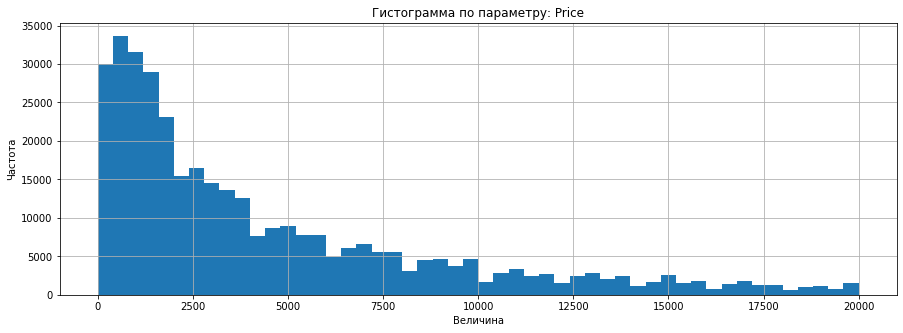

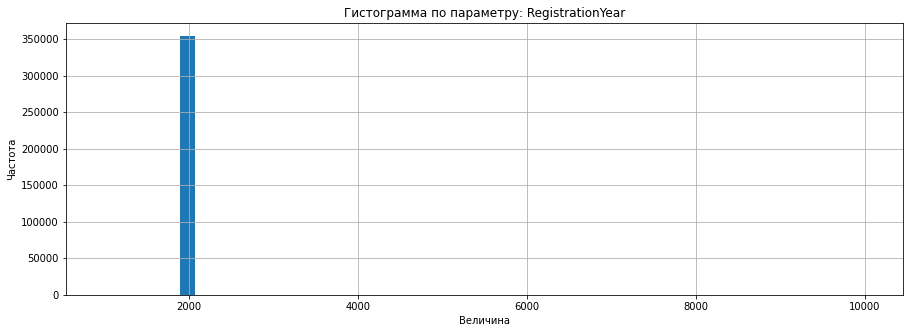

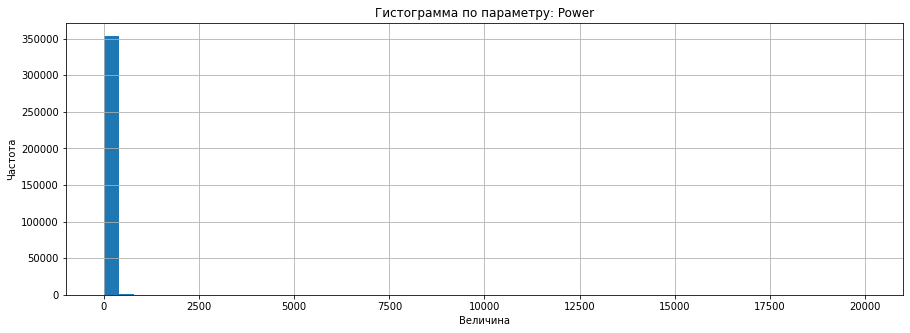

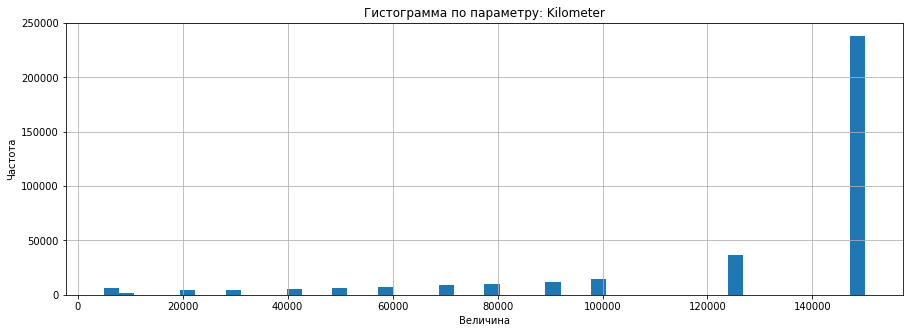

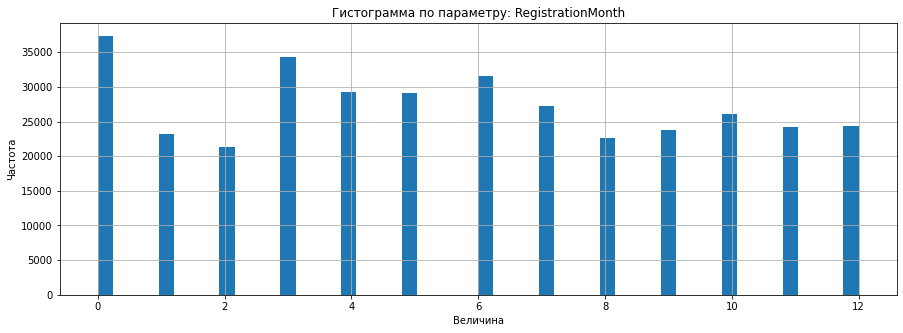

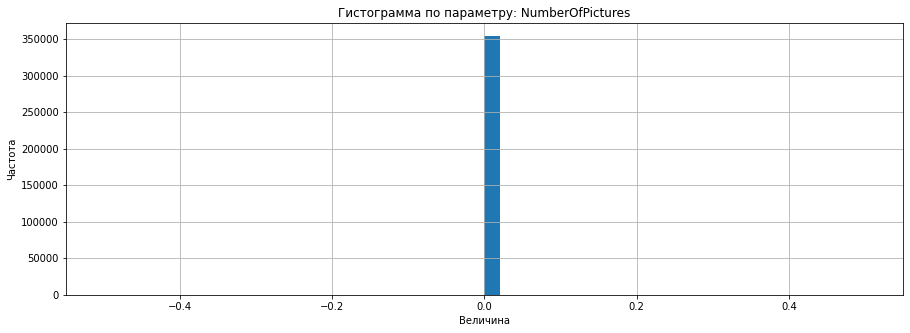

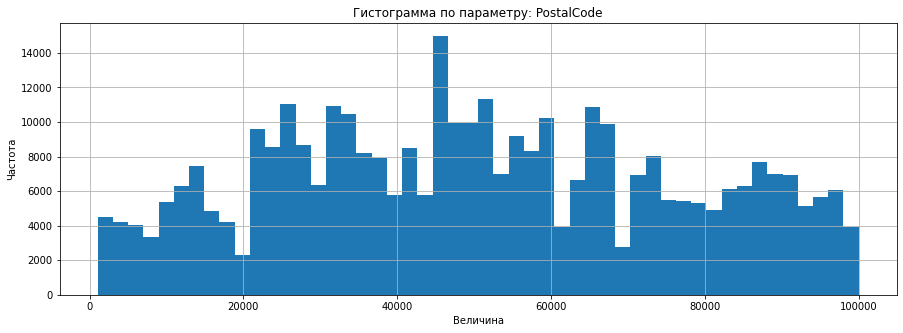

In [11]:
common_info(autos_df)

### Промежуточные выводы по разделу 1

1. Выполнена загрузка и просмотр данных:
    * Выполнен импорт необходимых библиотек и модулей. Данные успешно загружены из предоставленного файла.
    * Датафрейм autos_df содержит данные о характеристиках автомобилей.


2. Выполнен первичный анализ информации:
 1. Датафрейм содержит 354369 объектов;
 2. Типы данных:
    * столбцы с датами (DateCrawled, DateCreated, LastSeen) имеют тип object, по остальным столбцам замечаний по типам данных нет;
 3. Пропуски:
    * пропуски присутствуют в пяти столбцах: VehicleType (37490), Gearbox (19833), Model (19705), FuelType (32895), Repaired (71154);
 4. Названия столбцов не соответствуют устоявшимся требованиям;
 5. Столбцы RegistrationYear и Power имеют аномальные значения;
 6. *Из-за большого количества значений в категориальных признаков их вывод в виде графиков в данном разделе не выполнялся. Категориальные признаки будут проанализированы в исследовательском анализе данных.*
 7. Все значения столбца NumberOfPictures равны нулю.
 8. Столбец Price (целевой признак) имеет значения равные нулю. Данные значения необходимо обработать перед обучением модели, т.к. они могут негативно сказаться на предсказаниях модели.
 9. Столбец с месяцем регистрации автомобиля имеет 13 значений, а месяцев всего 12. Вероятно нулевые значения являются ошибочными. У нас нет возможности их заменить, т.к. нет зависимых признаков. Удаление данных значений также является нецелесообразным, т.к. их довольно много. Поэтому оставим их без изменений.


3. **Необходимо:**
 1. Удалить явные дубликаты, выполнить проверку на наличие неявных дубликатов, при наличии - устранить;
 2. Изменить тип данных в столбце DateCreated с датами на timestamp или date;
 3. Обработать пропуски: заполнить или удалить;
 4. Изменить названия столбцов (необязательно);
 5. Проверить и удалить аномальные значения в столбцах RegistrationYear и Power.
 6. Удалить столбцы NumberOfPictures, DateCrawled, LastSeen, PostalCode.
 7. Удалить строки с нулевым значением цены и ценой менее 200 евро.
 8. Создать столбец с объединенным названием бренда и модели и удалить исходные столбцы.

## Предобработка данных

###  Изменение названий столбцов

In [12]:
autos_df.columns = autos_df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()
autos_df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Названия столбцов успешно изменены.

###  Проверка наличия и устранение пропущенных значений

In [13]:
autos_df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

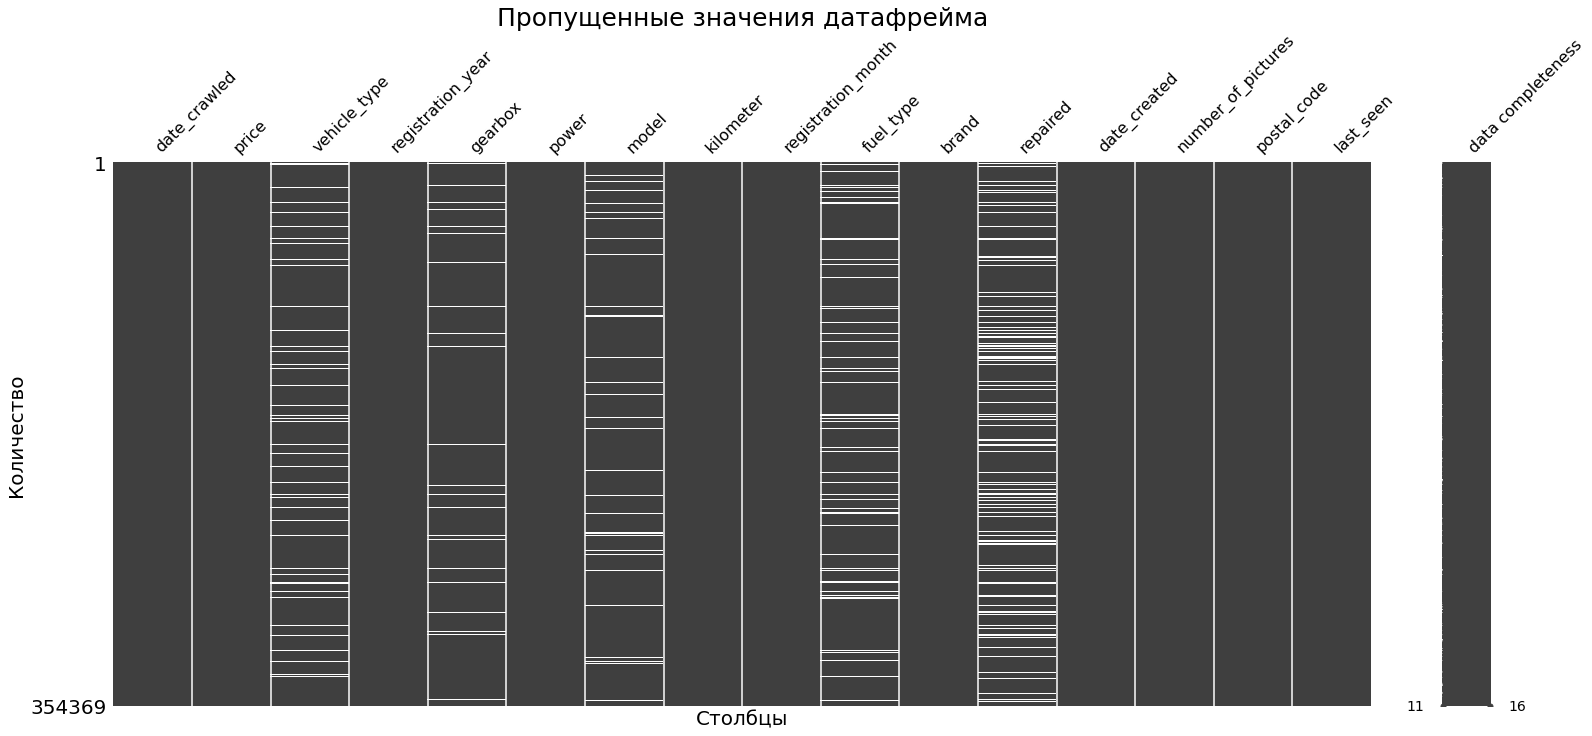

In [14]:
msno.matrix(autos_df, labels=True)
plt.title('Пропущенные значения датафрейма', fontsize=25)
plt.xlabel('Столбцы', fontsize=20)
plt.ylabel('Количество', fontsize=20)
plt.show()

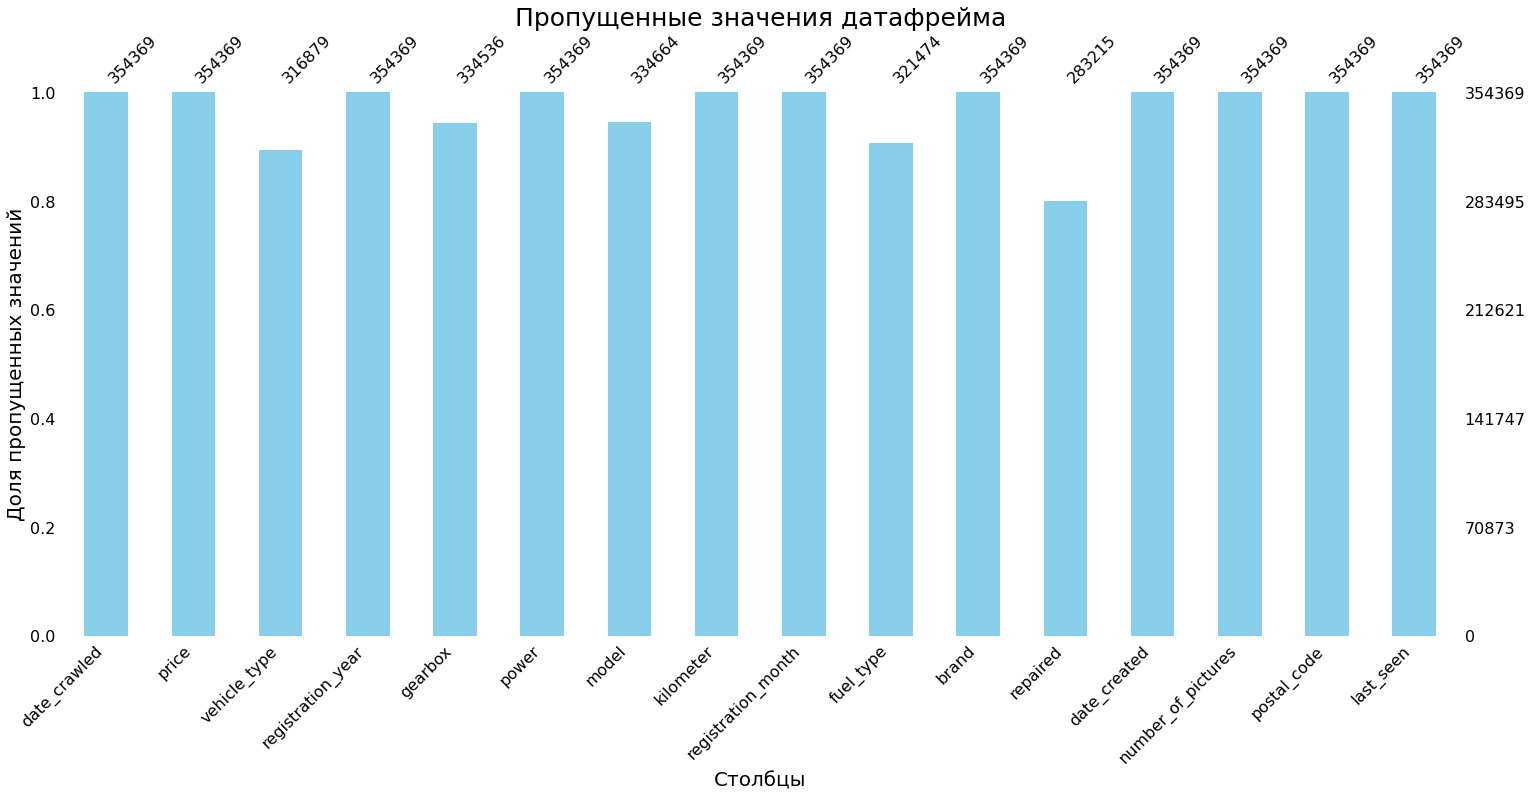

In [15]:
ax = msno.bar(autos_df, color='skyblue')
ax.set_title('Пропущенные значения датафрейма', fontsize=25)
ax.set_xlabel('Столбцы', fontsize=20)
ax.set_ylabel('Доля пропущенных значений', fontsize=20)
plt.show()

В данном датафрейме содержится большое количество пропусков в столбцах: vehicle_type (37490), gearbox (19833), model (19705), fuel_type (32895), repaired (71154).

Пропуски в столбцах vehicle_type и fuel_type можно заполнить по марке и модели автомобиля.

Пропуски в столбце repaired заполнить невозможно, т.к. нет "зависимых" признаков.

Пропуски в столбцах model и gearbox также заполнить нельзя, т.к. нет "зависимых" признаков. У одного автомобильного бренда существует несколько моделей автомобилей, а тип коробки передач может отличатся даже у одной модели в зависимости от комплектации.

Соответственно, **выполним заполнение пропусков в столбцах vehicle_type и fuel_type по марке и модели автомобиля, в столбце repaired заменим пропуски заглушкой. Остальные пропуски пока оставим незаполенными.** 

**Объединим названия моделей с брендами и удалим исходные столбцы с названиями моделей и брендами.**

Создадим новый столбец brand_model с объединенным названием бренда и модели.

In [16]:
autos_df['brand_model'] = autos_df['brand'].astype(str) + '_' + autos_df['model'].astype(str)

Удалим исходные столбцы с моделью и брендом для исключения дублирования информации.

In [17]:
autos_df = autos_df.drop(columns=['model', 'brand'], axis=1)
autos_df.shape

(354369, 15)

Новый столбец brand_model создан, исходные столбцы успешно удалены.

Создадим функцию для заполнения пропусков в столбце 'vehicle_type' по значениям в столбце brand_model ('model', 'brand')

In [18]:
def fill_vehicle_type(df):
    df['vehicle_type'] = df.groupby(['brand_model'])['vehicle_type'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )
    return df

Создадим функцию для заполнения пропусков в столбце 'fuel_type' по значениям в столбце brand_model ('model', 'brand')

In [19]:
def fill_fuel_type(df):
    df['fuel_type'] = df.groupby(['brand_model'])['fuel_type'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )
    return df

Применим поочередно обе функции для заполнения пропусков и выполним проверку.

In [20]:
autos_df = fill_vehicle_type(autos_df)
autos_df = fill_fuel_type(autos_df)

In [21]:
autos_df['repaired'] = autos_df['repaired'].fillna('unknown')

Заменим пропущенные значения в столбце repaired на заглушку unknown.

In [22]:
autos_df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
kilometer                 0
registration_month        0
fuel_type                 0
repaired                  0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
brand_model               0
dtype: int64

**Количество пропусков заментно уменьшилось:**
* Столбец vehicle_type: было 37490, стало 6828.
* Столбец fuel_type: было 32895, стало 7163.
* Столбец repaired: все пропуски заменены заглушкой unknown.

###  Изменение типа данных в столбце date_created с датами на дату формата datetime64[ns]

In [23]:
autos_df['date_created'] = pd.to_datetime(autos_df['date_created'], errors='coerce')
autos_df['date_created'].dtype

dtype('<M8[ns]')

Изменение типов данных в столбце date_created с датами прошло успешно. Все данные имеют формат datetime64[ns]

### Проверка наличия и устранение явных и неявных дубликатов

Приведем к нижему регистру все названия в столбцах с категориальным типом данных.

In [24]:
for column in autos_df[['vehicle_type', 'gearbox', 'brand_model', 'fuel_type']]: 
    autos_df[column] = autos_df[column].str.lower()

Выведем уникальные значения в данных столбцах

In [25]:
for column in autos_df[['vehicle_type', 'gearbox', 'brand_model', 'fuel_type']]: 
    print('==' *20 )
    print(autos_df[column].name)
    print('--' *20 )
    print(autos_df[column].value_counts())

vehicle_type
----------------------------------------
vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64
gearbox
----------------------------------------
gearbox
manual    268251
auto       66285
Name: count, dtype: int64
brand_model
----------------------------------------
brand_model
volkswagen_golf                  29232
bmw_3er                          19761
volkswagen_polo                  13066
opel_corsa                       12570
opel_astra                       10809
                                 ...  
rover_freelander                     3
land_rover_range_rover_evoque        2
rover_discovery                      2
land_rover_serie_1                   2
rover_defender                       1
Name: count, Length: 337, dtype: int64
fuel_type
----------------------------------------
fuel_type
petrol      244344
gasoline 

В столбце fuel_type есть два значения: petrol и gasoline. Это, по сути, одно и то же, но разница заключается в основном в географическом использовании этих терминов. На данном этапе не будем производить их объединение.

Посмотрим строки с явными дубликатами.

In [26]:
display(autos_df[autos_df.duplicated(keep=False)])

,date_crawled,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,repaired,date_created,number_of_pictures,postal_code,last_seen,brand_model
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,150000,7,gasoline,no,2016-03-18,0,36391,2016-03-18 18:46:15,volkswagen_passat
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,20000,7,petrol,no,2016-03-08,0,89518,2016-03-09 09:46:57,mercedes_benz_clk
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,150000,1,petrol,no,2016-03-28,0,66589,2016-03-28 08:46:21,suzuki_other
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,20000,7,petrol,no,2016-03-08,0,89518,2016-03-09 09:46:57,mercedes_benz_clk
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,125000,6,petrol,yes,2016-04-03,0,75196,2016-04-07 09:44:54,mercedes_benz_clk
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,150000,1,petrol,no,2016-03-28,0,66589,2016-03-28 08:46:21,suzuki_other
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,125000,6,petrol,yes,2016-04-03,0,75196,2016-04-07 09:44:54,mercedes_benz_clk
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,150000,7,gasoline,no,2016-03-18,0,36391,2016-03-18 18:46:15,volkswagen_passat


Удалим явные дубликаты.

In [27]:
autos_df = autos_df.drop_duplicates()

autos_df.duplicated().sum()

0

Явные дубликаты удалены. Неявные дубликаты не выявлены.

### Удаление аномальных значений в столбцах registration_year и power

In [28]:
for column in autos_df[['registration_year', 'power']]: 
    print('==' *20 )
    print(autos_df[column].name)
    print('--' *20 )
    print(autos_df[column].value_counts())

registration_year
----------------------------------------
registration_year
2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: count, Length: 151, dtype: int64
power
----------------------------------------
power
0       40225
75      24023
60      15897
150     14590
101     13298
        ...  
610         1
6006        1
5815        1
6018        1
1241        1
Name: count, Length: 712, dtype: int64


Мы видим наличие аномальных значений в каждом из столбцов. 

По мощности автомобилей нормальными являются значения до 1000 л.с. Причем такая большая мощность есть только у "специфических" автомобилей, например, у Ford Mustang GT, Chevrolet Camaro, Porsche 911, Nissan GT-R, Dodge Challenger Hellcat.

Мощность равная 0 и мощность менее 30 л.с. является ошибочной, выполним их замену по марке и модели автомобиля.
Также на данном этапе удалим все значения более 1000 л.с.

Большинство объектов в базе данных указаны за 2016 год (март и апрель), поэтому мы удалим все значения позднее апреля 2016 года и ранее 1900. Т.к. автомобиль не может быть выпущен позднее апреля 2016 года, а автомобили выпущенные ранее 1900 являются довольно редкими и имеют свою специфику ценообразования, которая может не зависеть от многих признаков.

Оставим в датафрейме только объекты в диапазоне 1900 - апрель 2016 в столбце 'registration_year'

In [29]:
autos_df = autos_df[(autos_df['registration_year'] >= 1900) & (autos_df['registration_year'] < 2017)]

autos_df = autos_df.drop(autos_df[(autos_df['registration_month'] > 4) & (autos_df['registration_year'] == 2016)].index).reset_index(drop=True)

Заменим все нулевые значения в столбце power на пропуски, затем создадим и применим функцию для замены пропусков в столбце 'power' на медиану по столбцу 'brand_model'.

In [30]:
autos_df.loc[autos_df['power'] == 0, 'power'] = np.nan

In [31]:
def change_zero_power(df):
    df['power'] = df.groupby(['brand_model'])['power'].transform(
        lambda x: x.fillna(x.median())
    )
    return df

In [32]:
autos_df = change_zero_power(autos_df)
autos_df.head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,repaired,date_created,number_of_pictures,postal_code,last_seen,brand_model
0,2016-03-24 11:52:17,480,NaN,1993,manual,101.0,150000,0,petrol,unknown,2016-03-24,0,70435,2016-04-07 03:16:57,volkswagen_golf
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,125000,5,gasoline,yes,2016-03-24,0,66954,2016-04-07 01:46:50,audi_nan
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,125000,8,gasoline,unknown,2016-03-14,0,90480,2016-04-05 12:47:46,jeep_grand
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,150000,6,petrol,no,2016-03-17,0,91074,2016-03-17 17:40:17,volkswagen_golf
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,90000,7,gasoline,no,2016-03-31,0,60437,2016-04-06 10:17:21,skoda_fabia
5,2016-04-04 17:36:23,650,sedan,1995,manual,102.0,150000,10,petrol,yes,2016-04-04,0,33775,2016-04-06 19:17:07,bmw_3er
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109.0,150000,8,petrol,no,2016-04-01,0,67112,2016-04-05 18:18:39,peugeot_2_reihe
7,2016-03-21 18:54:38,0,sedan,1980,manual,50.0,40000,7,petrol,no,2016-03-21,0,19348,2016-03-25 16:47:58,volkswagen_other
8,2016-04-04 23:42:13,14500,bus,2014,manual,125.0,30000,8,petrol,unknown,2016-04-04,0,94505,2016-04-04 23:42:13,ford_c_max
9,2016-03-17 10:53:50,999,small,1998,manual,101.0,150000,0,petrol,unknown,2016-03-17,0,27472,2016-03-31 17:17:06,volkswagen_golf


Удалим аномальные значения в столбце power

In [33]:
autos_df = autos_df[(autos_df['power'] >=30) & (autos_df['power'] <=1000)]

Проверим удаление и замены в столбцах 'registration_year', 'power'

In [34]:
for column in autos_df[['registration_year', 'power']]: 
    print('==' *20 )
    print(autos_df[column].name)
    print('--' *20 )
    print(autos_df[column].value_counts())

registration_year
----------------------------------------
registration_year
2000    24441
1999    22688
2005    22067
2001    20093
2006    19865
        ...  
1915        1
1920        1
1940        1
1927        1
1946        1
Name: count, Length: 94, dtype: int64
power
----------------------------------------
power
75.0     24219
60.0     19172
150.0    16510
101.0    15877
90.0     14422
         ...  
584.0        1
612.0        1
519.0        1
337.0        1
377.0        1
Name: count, Length: 462, dtype: int64


In [35]:
autos_df.shape

(333678, 15)

### Удаление столбцов number_of_pictures, date_crawled, last_seen, postal_code

Признаки с датами date_crawled, last_seen, postal_code никак не влияют на ценообразование автомобиля. Поэтому удалим их из датафрейма.
Также убедимся, что все значения столбца number_of_pictures равны нулю. И удалим его.

In [36]:
autos_df['number_of_pictures'].value_counts()

number_of_pictures
0    333678
Name: count, dtype: int64

Удалим данный столбец.

In [37]:
autos_df = autos_df.drop(columns=['number_of_pictures', 'date_crawled', 'last_seen', 'postal_code'], axis=1)
autos_df.shape

(333678, 11)

Четыре столбца успешно удалены.

### Просмотр уникальных значений столбца price и исправление аномальных значений

In [38]:
autos_df['price'].value_counts()

price
0        9652
500      5310
1500     4985
1000     4255
1200     4247
         ... 
1379        1
5377        1
3021        1
1368        1
14989       1
Name: count, Length: 3687, dtype: int64

Удалим все строки с нулевым значением и значением менее 200 евро в столбце price. Они могут быть реальными (например, если состояние авто очень плохое), но такие значения могут негативно сказаться на обучении и предсказаниях модели.

In [39]:
autos_df = autos_df[autos_df['price'] >= 200]

In [40]:
autos_df['price'].value_counts()

price
500      5310
1500     4985
1000     4255
1200     4247
2500     4169
         ... 
5377        1
3021        1
1368        1
233         1
14989       1
Name: count, Length: 3575, dtype: int64

Все строки с нулевыми и аномально низкими значениями удалены.

### Просмотр уникальных значений столбца date_created и исправление аномальных значений

In [41]:
autos_df['date_created'].value_counts().sort_index() 

date_created
2014-03-10        1
2015-03-20        1
2015-06-18        1
2015-08-07        1
2015-08-10        1
              ...  
2016-04-03    12425
2016-04-04    11996
2016-04-05     3627
2016-04-06      976
2016-04-07      479
Name: count, Length: 108, dtype: int64

В 2014 году было создано только одно объявление. В 2015 всего несколько объявлений. Значения за 2014 и 2015 годы являются устаревшими, т.к. они не учитывают уровень инфляции. Чтобы не учитывать их при обучении модели удалим данные за 2014 и 2015 годы и построим гистограмму.

In [42]:
autos_df = autos_df[autos_df['date_created'] >= '2016-01-01']

In [43]:
autos_df['date_created'].value_counts().sort_index() 

date_created
2016-01-02        4
2016-01-03        1
2016-01-06        1
2016-01-07        3
2016-01-08        1
              ...  
2016-04-03    12425
2016-04-04    11996
2016-04-05     3627
2016-04-06      976
2016-04-07      479
Name: count, Length: 89, dtype: int64

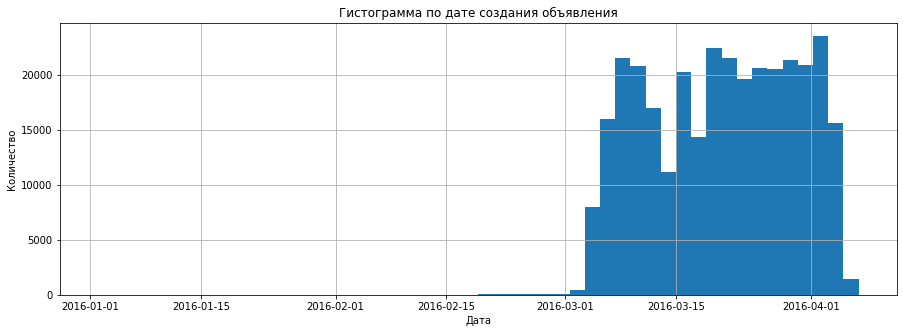

In [44]:
autos_df['date_created'].hist(bins=50, figsize=(15, 5))
plt.title('Гистограмма по дате создания объявления')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Из гистограммы видно, что большинство данных были занесены в базу с марта по апрель 2016 года.

In [45]:
autos_df.shape

(317712, 11)

###  Промежуточные выводы по разделу 2

1. Выполнено изменение названий столбцов.
2. Выполнена проверка наличия пропущенных значений:
 * в пяти столбцах присутствует большое количество пропусков (vehicle_type (37490), gearbox (19833), model (19705), fuel_type (32895), repaired (71154)). 
 * заполнение пропусков выполнено модой в двух столбцах по модели и марке автомобиля: столбец vehicle_type: было 37490, стало 6828; столбец fuel_type: было 32895, стало 7163.
 * в остальных столбцах замену пропусков выполнить невозможно
3. Выполнено изменение типов данных в столбце date_created с датами на дату формата datetime64[ns]
4. Выполнена проверка наличия и устранение явных и неявных дубликатов:
 * найдены и удалены 4 явных дубликата;
 * неявные дубликаты не выявлены.
 * в столбце fuel_type есть два значения: petrol и gasoline. Это, по сути, одно и то же, но разница заключается в основном в географическом использовании этих терминов. На данном этапе не будем производить их объединение.
5. Выполнено удаление аномальных значений в столбцах registration_year (оставлен диапазон 1900 - апрель 2016) и power (отсавлен диапазон 30 - 1000 л.с.).
6. Выполнено удаление столбца number_of_pictures, т.к. в нем все значения нулевые.
7. Выполнено удаление столбцов date_crawled и last_seen, postal_code, т.к. они не влияют на ценообразование.
8. **Столбец price (целевой признак) имеет 8462 значений равных нулю.** Эти значения могут быть правдой, если состояние авто неудовлетворительное. Данные значения можно заменить средними или медианными по марке и модели автомобиля (также как мы делали для заполнения пропусков в столбцах vehicle_type и fuel_type). Но **т.к. данный признак является целевым, принято решение удалить строки с нулевыми значениями, чтобы не влиять ими на обучение моделей.**
9. Выполнено удаление данных по столбцу date_created за 2014 и 2015 годы, т.к. они могут негативно сказаться на обучение модели.
10. В столбце repaired создана заглушка.
11. Создан столбец с объединенным названием бренда и модели, исходные столбцы удалены.

**После обработки данных и удаления аномальных значений осталось 317712 из 354369 объектов**

**Данные подготовлены к исследовательскому анализу.**

## Исследовательский анализ данных

### Статистический анализ всех признаков

**Создадим функцию для вывода статистических данных датафрейма:**
* таблица статистических данных;
* гистограмма и ящик с усами для количественного признака.

In [46]:
def statistics(data):
    display(data.describe())
    print('Количественные признаки датафрейма:')
    print(data.select_dtypes(include=[np.number]).columns)
    
    for column1 in data.select_dtypes(include=[np.number]).columns: 
        print(data[column1].name)
        print(data[column1].value_counts())

        plt.subplot(2, 1, 1)
        data[column1].hist(bins=50, figsize=(15, 10))
        plt.title(f'Гистограмма по параметру: {column1}')
        plt.xlabel('Величина')
        plt.ylabel('Частота')
        
        plt.axvline(data[column1].mean(), color='red')
        plt.axvline(data[column1].median(), color='blue')
        plt.legend(['Среднее значение',
                'Медиана',
                f'Распределение значений по параметру: {column1}'
               ])
        
        plt.subplot(2, 1, 2)
        plt.ylim()
        plt.boxplot(data[column1], vert=False)
        plt.title(f'Ящик с усами по параметру: {column1}')
        plt.xlabel('Величина')
        plt.ylabel('Характеристика')
        plt.show()  

    return 

Применим данную функцию.

,price,registration_year,power,kilometer,registration_month,date_created
count,317712.000000,317712.000000,317712.000000,317712.000000,317712.000000,317712
mean,4730.245200,2002.545875,120.584836,128452.954248,5.838634,2016-03-20 19:15:09.110137600
min,200.000000,1910.000000,30.000000,5000.000000,0.000000,2016-01-02 00:00:00
25%,1299.000000,1999.000000,80.000000,125000.000000,3.000000,2016-03-13 00:00:00
50%,2999.000000,2003.000000,111.000000,150000.000000,6.000000,2016-03-21 00:00:00
75%,6832.500000,2007.000000,150.000000,150000.000000,9.000000,2016-03-29 00:00:00
max,20000.000000,2016.000000,1000.000000,150000.000000,12.000000,2016-04-07 00:00:00
std,4558.685244,6.594259,53.469640,36998.809872,3.663200,NaN


Количественные признаки датафрейма:
Index(['price', 'registration_year', 'power', 'kilometer',
       'registration_month'],
      dtype='object')
price
price
500      5310
1500     4985
1000     4255
1200     4247
2500     4169
         ... 
5377        1
3021        1
1368        1
233         1
14989       1
Name: count, Length: 3575, dtype: int64


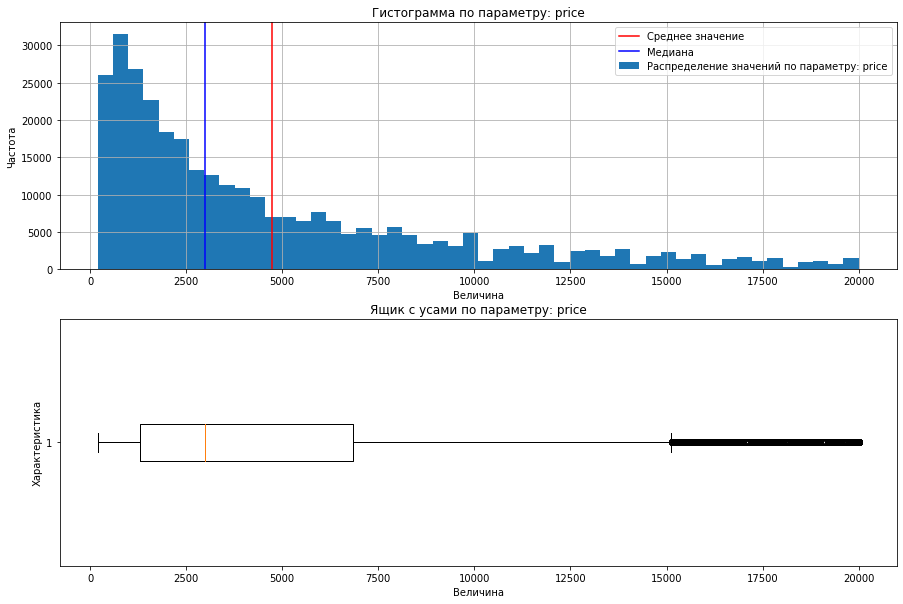

registration_year
registration_year
2000    22044
1999    21498
2005    21254
2006    19600
2001    19456
        ...  
1925        1
1933        1
1940        1
1949        1
1946        1
Name: count, Length: 90, dtype: int64


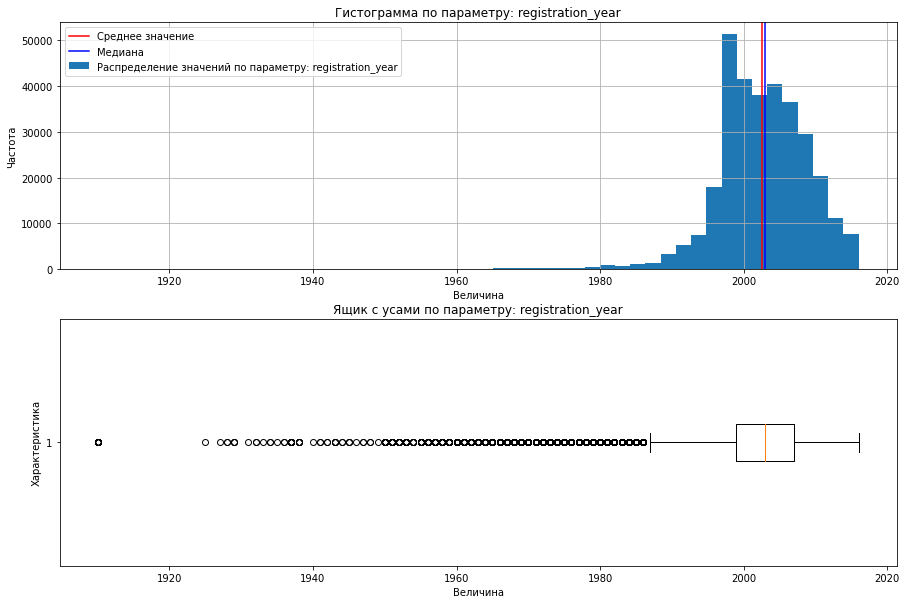

power
power
75.0     22816
60.0     17315
150.0    15514
101.0    14944
90.0     13225
         ...  
584.0        1
602.0        1
612.0        1
519.0        1
377.0        1
Name: count, Length: 455, dtype: int64


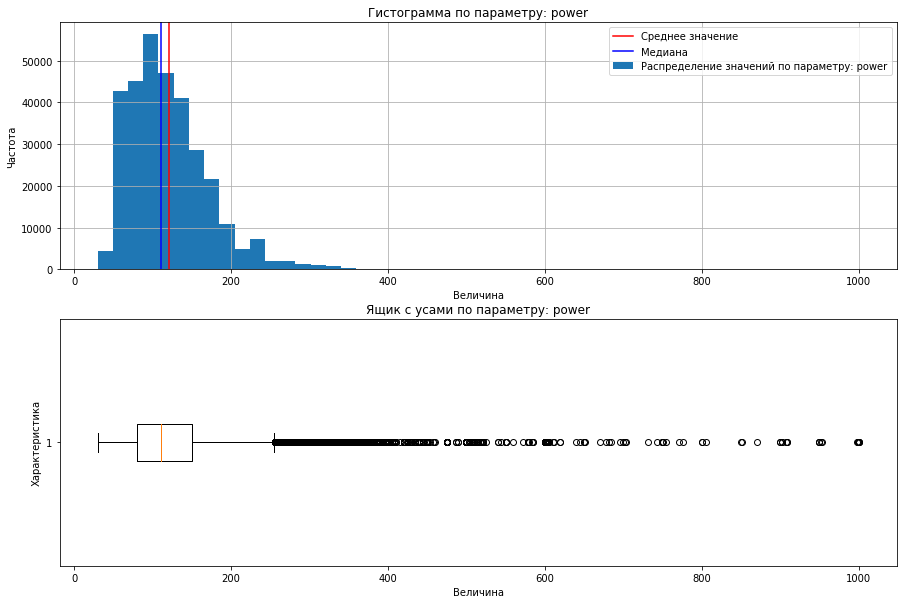

kilometer
kilometer
150000    212299
125000     33599
100000     13576
90000      10808
80000       9386
70000       8071
60000       7038
50000       5841
40000       4632
30000       4054
5000        3968
20000       3468
10000        972
Name: count, dtype: int64


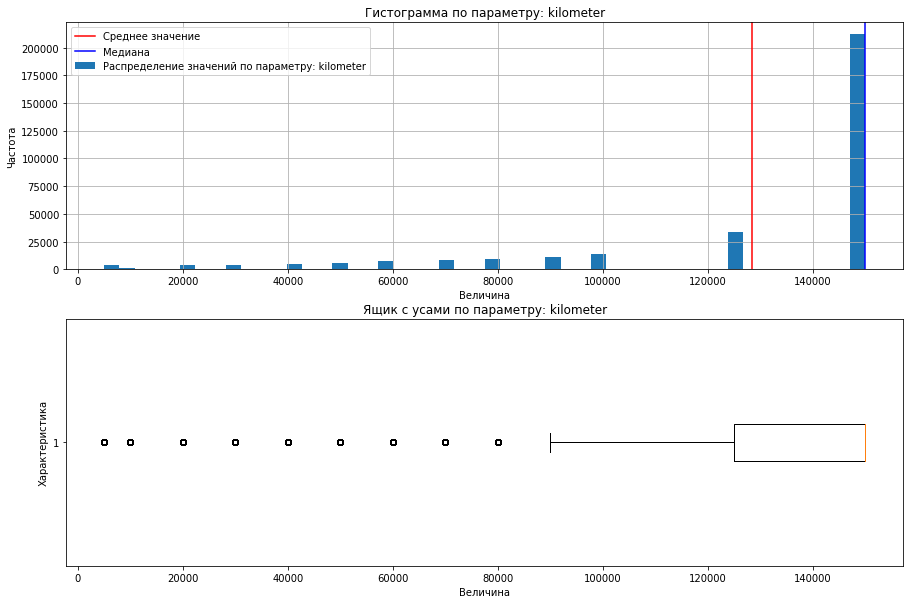

registration_month
registration_month
3     32142
6     28608
4     27165
0     26529
5     26461
7     24856
10    23933
11    22226
12    22151
9     21893
1     21422
8     20539
2     19787
Name: count, dtype: int64


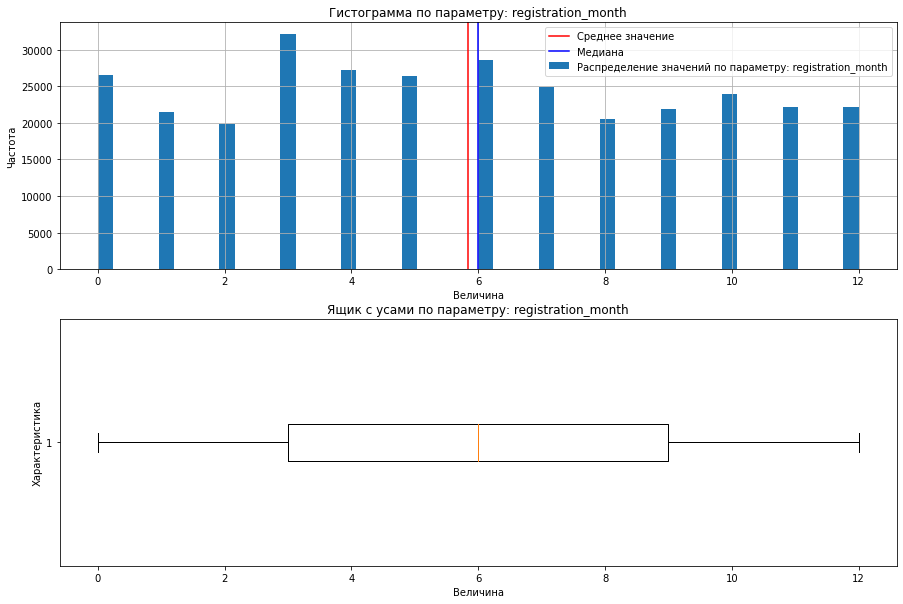

In [47]:
statistics(autos_df)

По четырем категориальным признакам выведем круговые диаграммы. Новый категориальный признак имеют большое количество значений 'brand_model', поэтому по нему не удастся построить информативную круговую диаграмму.

vehicle_type
vehicle_type
sedan          88252
small          75238
wagon          62976
bus            28168
convertible    19691
coupe          15418
suv            11733
other           2914
Name: count, dtype: int64


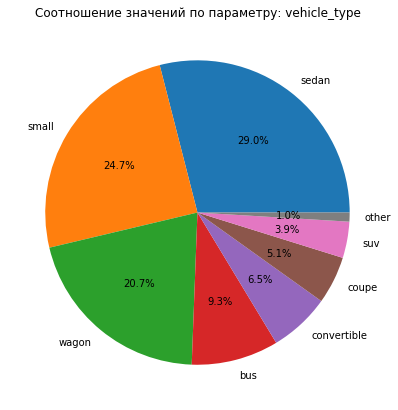

gearbox
gearbox
manual    242533
auto       61878
Name: count, dtype: int64


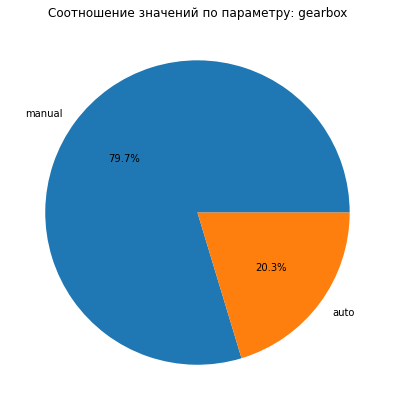

fuel_type
fuel_type
petrol      215021
gasoline     96854
lpg           4960
cng            518
hybrid         213
other           99
electric        47
Name: count, dtype: int64


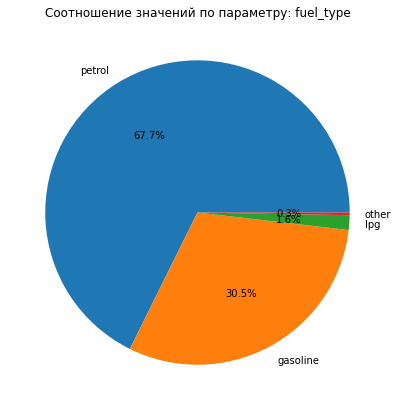

repaired
repaired
no         232941
unknown     54377
yes         30394
Name: count, dtype: int64


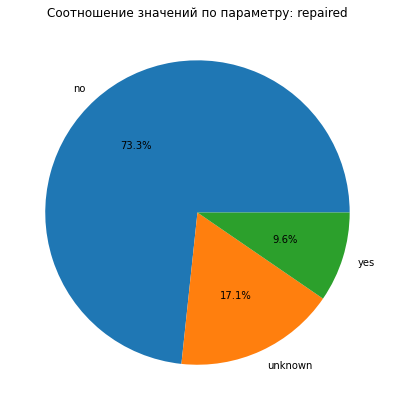

In [48]:
for cat in autos_df[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']]:     
    print(autos_df[cat].name)
    print(autos_df[cat].value_counts())
    value_counts = autos_df[cat].value_counts()
    rare_categories = value_counts[value_counts < 3000].index
    autos_df[cat] = autos_df[cat].replace(rare_categories, 'other')
    final_counts = autos_df[cat].value_counts()
    plt.figure(figsize=(10, 7))
    plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%')  
    plt.title(f'Соотношение значений по параметру: {cat}')
    plt.show()

#### Выводы по статистическому анализу датафрейма autos_df

**Количественные признаки:** 'price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code'.

1. **Признак 'price':** 
 1. Гистограмма имеет нормальное распределение со смещением влево. 
 2. По диаграмме размаха нормальный диапазон значений от 200 до 15000. Среднее значение равно 4740.,  медиана примерно равна 3000. Минимальное значение равно 200, максимальное - 20000. Часть значений выходит за нормальный диапазон. По данному признаку ранее уже выполнялось удаление аномальных значений.

2. **Признак 'registration_year':** 
 1. Гистограмма имеет пиковые значения.
 2. По диаграмме размаха нормальный диапазон значений от 1986 до 2016. Среднее значение и медиана примерно равны 2002. Минимальное значение равно 1910, максимальное - 2016. Часть значений выходит за нормальный диапазон, но таких значений немного и они могут быть реальными. По данному признаку ранее уже выполнялось удаление аномальных значений.

3. **Признак 'power':** 
 1.  Гистограмма имеет нормальное распределение с двумя пиками и смещением влево.
 2. По диаграмме размаха нормальный диапазон значений от 30 до 250. Среднее значение равно 120, медиана примерно равна 115. Минимальное значение равно 30, максимальное - 1000. Часть значений выходит за нормальный диапазон, но таких значений немного и они могут быть реальными. По данному признаку ранее уже выполнялось удаление аномальных значений.
 
4. **Признак 'kilometer':** 
 1. Гистограмма имеет всего 13 значений с шагом примерно 10000 км.
 2. При таком количестве значений параметр скорее относится к категориальным, чем к количественным. И по нему не имеет смысла определять нормальный диапазон, среднее и медиану. Большинство автомобилей имеют пробег 150000 км.
 
5. **Признак 'registration_month':** 
 1. Гистограмма имеет всего 13 значений. Что является ошибкой, т.к. месяцев 12. Т.к. нулевое значение имеют почти 24000 объектов. Принято решение оставить его.
 3. При таком количестве значений параметр скорее относится к категориальным, чем к количественным. И по нему не имеет смысла определять нормальный диапазон, среднее и медиану.
 
6. **Признак 'postal_code':** 
 1. По гистограмме наблюдается нормальное распределение значений с большим количеством пиков. 
 3. Данный параметр показывает почтовый индекс владельца автомобиля. Теоретически, если знать страну базы данных, то по данному параметру можно определить локацию нахождения автомобиля (область, регион, город), которая может напрямую влиять на стоимость автомобиля. Но т.к. мы не знаем страну, данный параметр для нас бесполезен. 

**Категориальные признаки** (с небольшим количеством значений): 'vehicle_type', 'gearbox', 'fuel_type', 'repaired'.

1. **Признак 'vehicle_type':**
 1. В пятерку лидеров по типу кузова входят:
    * sedan       - 29,6 (93047)
    * small       - 25,0 (78362)
    * wagon       - 20,4 (64102)
    * bus         - 9,3 (29247)
    * convertible - 6,2 (19562)
    
    
2. **Признак 'gearbox':**
 1. По типу коробки передач имеем следующие доли:
    * manual      - 79,8 (242618)
    * auto        - 20,2 (61551)

3. **Признак 'fuel_type':**
 1. По типу топлива имеем следующих лидеров:
    * petrol      - 67,3 (210592) (бензин)
    * gasoline    - 30,9(96682) (бензин)
    * lpg         - 1,6 (4828) (СПГ - сжиженный нефтяной газ)
 
4. **Признак 'repaired':**
 1. По признаку "Был в ремонте" имеем следующие доли:
    * no          - 88,6 (232951)
    * yes         - 11,4 (30060)

### Корреляционный анализ признаков

#### Вывод матрицы phik_matrix по коэффициентам корреляции датафрейма

**Phik_matrix** позволяет анализировать корреляцию между числовыми, категориальными, интервальными и порядковыми переменными, а также эффективно фиксирует нелинейные зависимости

In [49]:
autos_df.phik_matrix()

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month']


,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,repaired,date_created,brand_model
price,1.000000,0.269696,0.597011,0.328244,0.465744,0.311562,0.149969,0.304871,0.340579,0.053156,0.582363
vehicle_type,0.269696,1.000000,0.167500,0.289595,0.358632,0.175848,0.073231,0.522459,0.101051,0.054998,0.921939
registration_year,0.597011,0.167500,1.000000,0.077784,0.158817,0.328244,0.099884,0.248513,0.206072,0.025611,0.622769
gearbox,0.328244,0.289595,0.077784,1.000000,0.548487,0.023802,0.044792,0.233176,0.020440,0.019282,0.663369
power,0.465744,0.358632,0.158817,0.548487,1.000000,0.085960,0.054557,0.268002,0.087268,0.000000,0.708572
kilometer,0.311562,0.175848,0.328244,0.023802,0.085960,1.000000,0.075750,0.160813,0.246401,0.044845,0.455800
registration_month,0.149969,0.073231,0.099884,0.044792,0.054557,0.075750,1.000000,0.073825,0.271369,0.038180,0.190217
fuel_type,0.304871,0.522459,0.248513,0.233176,0.268002,0.160813,0.073825,1.000000,0.045943,0.027964,0.591930
repaired,0.340579,0.101051,0.206072,0.020440,0.087268,0.246401,0.271369,0.045943,1.000000,0.039114,0.309253
date_created,0.053156,0.054998,0.025611,0.019282,0.000000,0.044845,0.038180,0.027964,0.039114,1.000000,0.270300


In [50]:
interval_cols = ['price', 'registration_year', 'power']
phik_overview = phik_matrix(autos_df, interval_cols=interval_cols)

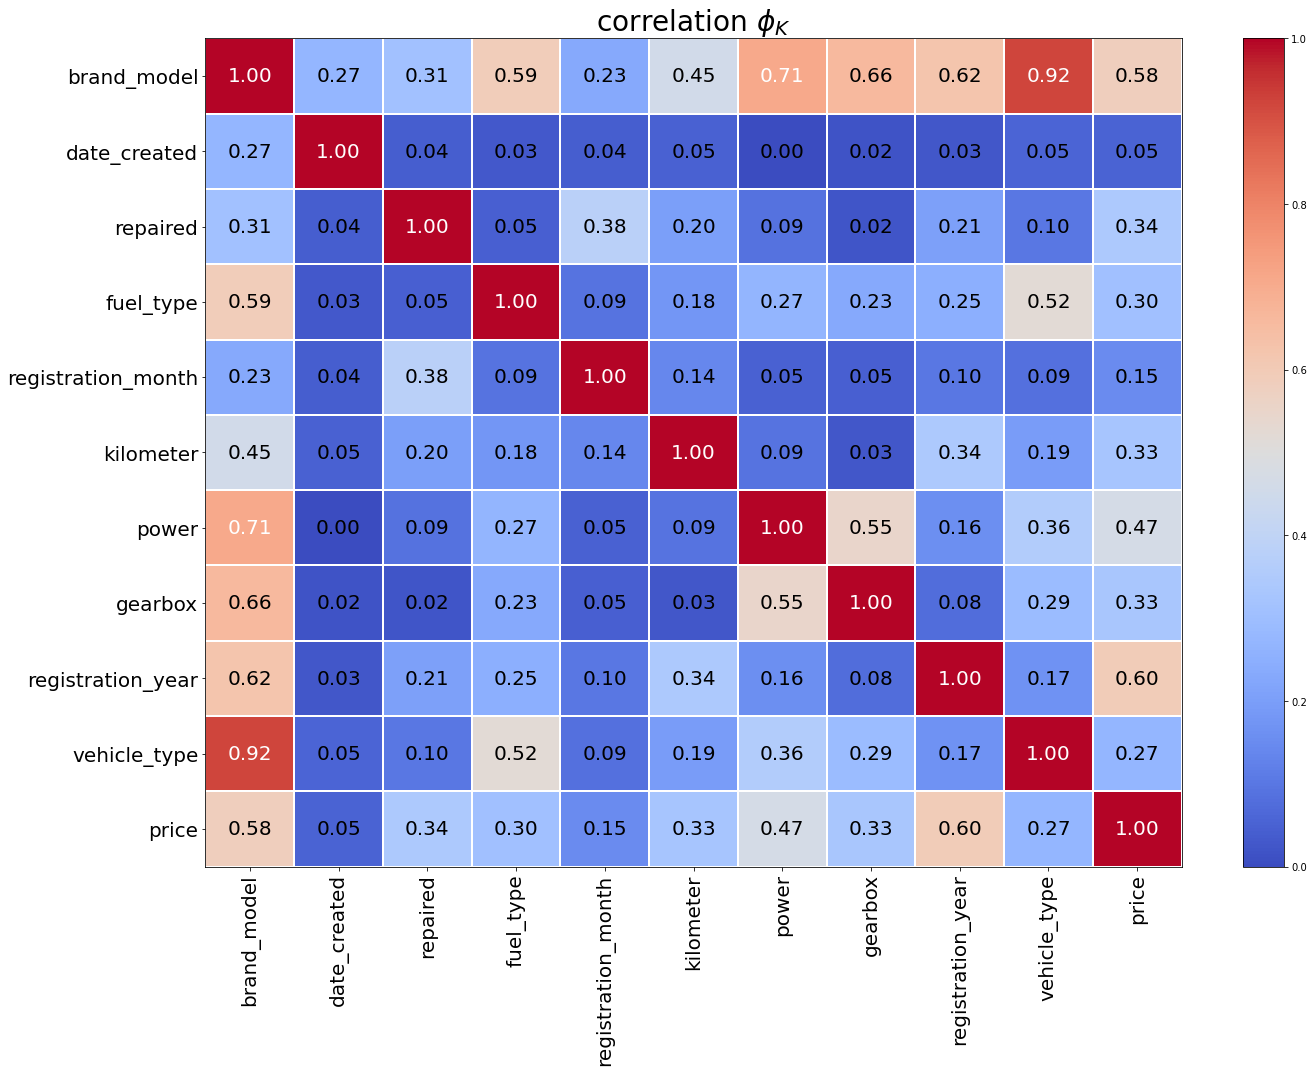

In [51]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
)

#### Визуальное отображение взаимосвязей между входными количественными признаками и целевым с группировкой по категориальным признакам

Применим функцию **sns.PairGrid()** для визуального отображения взаимосвязей между входными количественными признаками и целевым с группировкой по категориальным признакам

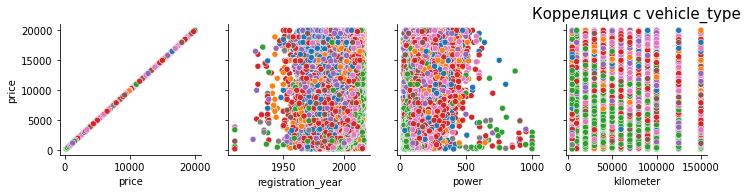

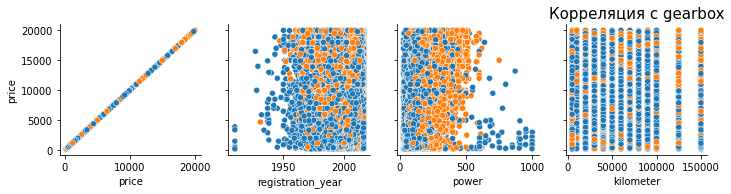

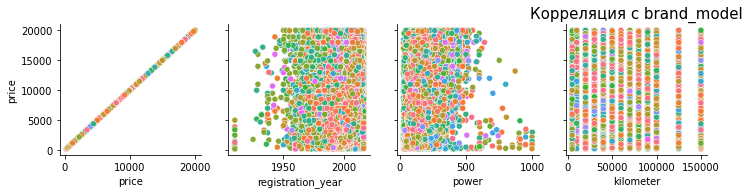

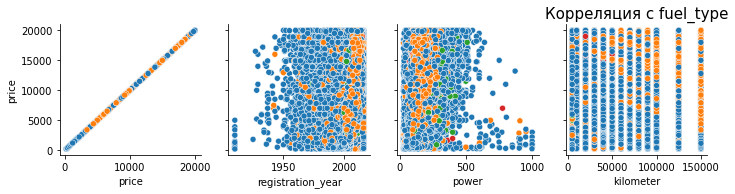

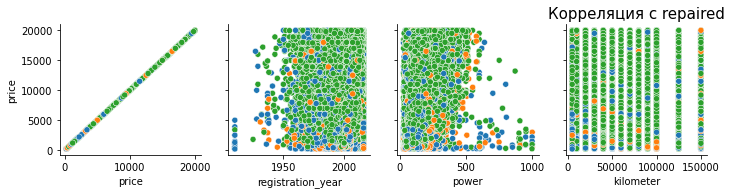

In [52]:
autos_df_cat = autos_df[['vehicle_type', 'gearbox', 'brand_model', 'fuel_type', 'repaired']]
autos_df_factor = autos_df[['price', 'registration_year', 'power', 'kilometer']]

for category in autos_df_cat:
    g = sns.PairGrid(autos_df, hue = category, x_vars=autos_df_factor, y_vars='price')    
    g.map(sns.scatterplot)
    plt.title(f'Корреляция с {category}', fontsize=15, )
plt.show()

#### Вычисление коэффициентов корреляции между столбцами датафрейма train_job_satisfaction_rate и интерпритация их по шкале Чеддока 

Создадим функцию для вычисления коэффициента корреляции между столбцами и интерпритации его по шкале Чеддока

In [53]:
def correlation(df):
    corr_matrix = phik_matrix(df, interval_cols=interval_cols)
    correlations = []
    rows, cols = corr_matrix.shape

    for i in range(cols):
        for j in range(i + 1, cols):
            corr_coef = corr_matrix.iloc[i, j]

            abs_corr = abs(corr_coef)
            strength_categories = ["Слабая", "Умеренная", "Заметная", "Высокая", "Весьма высокая"]
            thresholds = [0.3, 0.5, 0.7, 0.9, 1]  
            strength = next(
                category for category, threshold in zip(strength_categories, thresholds)
                if abs_corr <= threshold 
            )
            
            if strength in ["Слабая", "Умеренная", "Заметная", "Высокая", "Весьма высокая"]:
                correlations.append((
                    corr_coef, 
                    strength, 
                    corr_matrix.columns[i],
                    corr_matrix.columns[j]
                    ))

    correlations.sort(reverse=True)
    
    for corr_info in correlations:
        corr_coef, strength, col1, col2 = corr_info
        print()
        print(f"Для столбцов '{col1}' и '{col2}':")
        print("Коэффициент корреляции:", corr_coef.round(3))
        print("Интерпритация связи:", strength)

Применим созданную функцию.

In [54]:
correlation(autos_df)


Для столбцов 'vehicle_type' и 'brand_model':
Коэффициент корреляции: 0.922
Интерпритация связи: Весьма высокая

Для столбцов 'power' и 'brand_model':
Коэффициент корреляции: 0.709
Интерпритация связи: Высокая

Для столбцов 'gearbox' и 'brand_model':
Коэффициент корреляции: 0.663
Интерпритация связи: Заметная

Для столбцов 'registration_year' и 'brand_model':
Коэффициент корреляции: 0.623
Интерпритация связи: Заметная

Для столбцов 'price' и 'registration_year':
Коэффициент корреляции: 0.597
Интерпритация связи: Заметная

Для столбцов 'fuel_type' и 'brand_model':
Коэффициент корреляции: 0.592
Интерпритация связи: Заметная

Для столбцов 'price' и 'brand_model':
Коэффициент корреляции: 0.582
Интерпритация связи: Заметная

Для столбцов 'gearbox' и 'power':
Коэффициент корреляции: 0.548
Интерпритация связи: Заметная

Для столбцов 'vehicle_type' и 'fuel_type':
Коэффициент корреляции: 0.522
Интерпритация связи: Заметная

Для столбцов 'price' и 'power':
Коэффициент корреляции: 0.466
Интерприт

### Промежуточные выводы по разделу 3

**В данном разделе выполнены:**
1. Статистический анализ:
 * создана функция для вывода статистических данных датафрейма (таблица статистических данных, гистограмма и ящик с усами для количественного признака, круговая диаграмма для категориального признака);
 * выполнен статистический анализ датафрейма autos_df;
2. Корреляционный анализ:
 * выведена таблица и тепловая диаграмма по коэффициентам корреляции с помощью phik_matrix.
 * построена диаграмма взаимосвязей между входными количественными признаками и целевым с группировкой по категориальным признакам.
 * вычислены коэффициенты корреляции между столбцами и дана интерпретация их по шкале Чеддока.

**Статистический анализ позволяет сделать следующие выводы:**
1. Цена автомобилей имеет довольно широкий диапазон от 200 до 20000, со средним значением 4740 евро, а медианным около 3000 евро.
2. Год выпуска автомобилей тоже имеет довольно широкий диапазон, но больше всего автомобилей выпущенных с 1990 по 2015 годы.
3. В основном автомобили имеют мощность двигателя от 75 до 250 л.с.
4. Преобладают автомобили с большим пробегом. Почти 250000 автомобилей имеют пробег более 100000 км.
5. Месяца регистрации автомобилей распределены практически равномерно, но имеются данные с “нулевым” месяцем, что явно является ошибкой.
6. Существует много типов кузовов, но по количеству лидируют:
sedan - 29,6 (93047)
small - 25,0 (78362)
wagon - 20,4 (64102)
bus - 9,3 (29247)
convertible - 6,2 (19562)
7. Почти 80 % автомобилей имеют ручную коробку передач.
8. 98 % автомобилей используют в качестве топлива бензин.
9. Почти 89 % автомобилей не находились в ремонте.
10. В базе данных большое количество марок автомобилей, и ещё большее количество моделей. Подробный анализ марок и моделей не требуется для нашей задачи.

**Корреляционный анализ позволяет сделать следующие выводы:**
1. Наблюдается прямая весьма высокая корреляция между признаками:
 * 'vehicle_type' и 'brand_model' - 0.992;
2. Наблюдается прямая высокая корреляция между признаками:
 * 'power' и 'brand_model'  - 0.709;
3. Наблюдается прямая заметная корреляция между признаками:
 * 'gearbox' и 'brand_model' - 0.663;
 * 'registration_year' и 'brand_model'  - 0.623;
 * 'price' и 'registration_year'  - 0.597;
 * 'price' и 'brand_model  - 0.582;
 * 'fuel_type' и 'brand_model'  - 0.567;
 * 'gearbox' и 'power'  - 0.548;
4. Также десять признаков имеют умеренную корреляцию.
5. Целевой признак (price) имеет:
 *  заметную корреляцию с признаками: 'registration_year (0.597), 'brand_model (0.582);
 * умеренную корреляцию с признаками: power (0.466),  'repaired' (0.341), 'gearbox' (0.328), 'kilometer' (0.327).
6. По корреляционным диаграммам взаимосвязи выражены неявно.

 
**Все имеющиеся взаимосвязи выглядят логичными. На цену автомобиля больше всего влияют год выпуска, бренд и модель, а также мощность автомобиля, был ли он в ремонте, тип коробки передач и пробег** 

После предобработки и исследовательского анализа можно переходить к подготовке данных и обучению моделей.

## Обучение моделей

### Подготовка данных перед обучением моделей

1. Удалим столбцы с признаками, которые имеют слабую корреляцию с целевым, а именно: 'registration_month', 'date_created'.
2. Разделим датафрейм на тренировочную и тестовую выборки и на входные признаки и целевой признак.
3. Категориальные признаки vehicle_type, gearbox, fuel_type, repaired закодируем OneHotEncoder.
4. Категориальный признак с большим колличеством категорий 'brand_model' закодируем OrdinalEncoding
5. Создадим пайплайн с подготовкой данных перед машинным обучением

**Разделим датафрейм тренировочную и тестовую выборки, а также на входные и целевой признаки.**

In [55]:
autos_df.shape

(317712, 11)

In [56]:
X = autos_df.drop(columns=['price', 'registration_month', 'date_created'], axis=1)
y = autos_df['price']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=STATE)

In [57]:
print(f'Размер тренировочной выборки с входными признаками: {X_train.shape}')
print(f'Размер тестовой выборки с входными признаками: {X_test.shape}')
print(f'Размер тренировочной выборки с целевым признаком: {y_train.shape}')
print(f'Размер тестовой выборки с целевым признаком: {y_test.shape}')

Размер тренировочной выборки с входными признаками: (238284, 8)
Размер тестовой выборки с входными признаками: (79428, 8)
Размер тренировочной выборки с целевым признаком: (238284,)
Размер тестовой выборки с целевым признаком: (79428,)


Датафрейм успешно разделен на четыре выборки.

**Разделим категориальные и количественные признаки для их подготовки в пайплайне.**

In [58]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
ord_columns = ['brand_model']
num_columns = ['registration_year'] 

**Создадим пайплайн с подготовкой данных перед машинным обучением:**
1. Признаки 'vehicle_type', 'gearbox', 'fuel_type', 'repaired' обработаем с помощью OneHotEncoder.
2. Признак 'brand_model' обработаем с помощью OrdinalEncoder.
3. Пропуски обработаем с помощью SimpleImputer.
4. Признаки 'registration_year', 'registration_month', 'date_created' обработаем с помощью MinMaxScaler.

In [59]:
#создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False )) #sparse_output
    ]
)

#создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


#создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение моделей

**Создадим итоговой пайплайн для обучения и сравнения четырех моделей: DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor** 

Для трех моделей будем подбирать гиперпараметры.

In [60]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final_LGBMR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=STATE))
])

pipe_final_CBR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(random_state=STATE, verbose=False))
])

pipe_final_DTR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=STATE))
])


param_grid_LGBMR = [
   
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=STATE)],
        'models__learning_rate': [0.1, 0.2], 
        'models__num_leaves': [50, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

param_grid_CBR = [    
    
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(random_state=STATE, logging_level='Silent')], #, logging_level='Silent'
        'models__learning_rate': [0.1, 0.2],
        'models__depth': [4, 8],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    }
]    

param_grid_DTR = [    
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=STATE)],
        'models__max_depth': range(2, 12),
        'models__max_features': range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

**Создадим переменную для расчёта метрики root_mean_squared_error (RMSE)**

In [61]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [62]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

**С помощью RandomizedSearchCV найдем лучшую модель**

**Выберем лучшую модель LGBMRegressor**

In [63]:
randomized_search_LGBMR = RandomizedSearchCV(
    pipe_final_LGBMR, 
    param_grid_LGBMR, 
    n_iter=10,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_LGBMR.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                're...
                                                                               ['registration_year'])])),
                                             ('models',
                                              LGBMRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor(random_state=42)],
                                         'models__learning_rate': [0.1, 0.2],
                                         'models__num_leaves': [50, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

**Выберем лучшую модель CatBoostRegressor**

In [64]:
randomized_search_CBR = RandomizedSearchCV(
    pipe_final_CBR, 
    param_grid_CBR, 
    n_iter=6,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=1,
    error_score='raise'
)
randomized_search_CBR.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                're...
                                              <catboost.core.CatBoostRegressor object at 0x7f620df95f70>)]),
                   n_iter=6, n_jobs=1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x7f620df951c0>],
                                         'models__depth': [4, 8],
                                         'models__learning_rate': [0.1, 0.2],
                                         'preprocessor__num': [StandardScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

**Выберем лучшую модель DecisionTreeRegressor**

In [65]:
randomized_search_DTR = RandomizedSearchCV(
    pipe_final_DTR, 
    param_grid_DTR, 
    n_iter=10,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_DTR.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                're...
                                                                               ['registration_year'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 12),
                                         'models__max_features': range(2, 12),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

### Промежуточный вывод по разделу 4

1. Выполнена подготовка данных перед обучением моделей:
 1. Удалены столбцы с признаками, которые имеют слабую корреляцию с целевым, а именно: 'registration_month', 'date_created'.
 2. Датафрейм разделен на тренировочную и тестовую выборки и на входные признаки и целевой признак.
 3. Категориальные признаки vehicle_type, gearbox, fuel_type, repaired закодированы OneHotEncoder.
 4. Категориальные признаки с большим колличеством категорий 'Brand', 'Model' закодированы OrdinalEncoding
 5. Создан пайплайн с подготовкой данных перед машинным обучением.
2. Выполнено обучение и поиск лучших моделей с помощью RandomizedSearchCV:
 1. LGBMRegressor (с подбором гиперпараметоров).
 2. CatBoostRegressor (с подбором гиперпараметоров).
 3. DecisionTreeRegressor (с подбором гиперпараметоров)

## Анализ моделей и выбор лучшей

### Вывод лучших моделей и расчет их метрик RMSE

In [67]:
print('Лучшая модель randomized_search_LGBMR и её параметры:\n\n', randomized_search_LGBMR.best_estimator_)
print('Метрика лучшей модели randomized_search_LGBMR на кросс-валидации:', randomized_search_LGBMR.best_score_)

print('Лучшая модель randomized_search_CBR и её параметры:\n\n', randomized_search_CBR.best_estimator_)
print('Метрика лучшей модели randomized_search_CBR на кросс-валидации:', randomized_search_CBR.best_score_)

print('Лучшая модель randomized_search_DTR и её параметры:\n\n', randomized_search_DTR.best_estimator_)
print('Метрика лучшей модели randomized_search_DTR на кросс-валидации:', randomized_search_DTR.best_score_)

Лучшая модель randomized_search_LGBMR и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired']),
                                                 ('ord',
   

### Вывод параметров всех обученных моделей

In [68]:
print('Таблица с обученными моделями randomized_search_LGBMR')
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame(randomized_search_LGBMR.cv_results_)
display(results[['rank_test_score', 'mean_test_score', 'mean_fit_time',
                 'mean_score_time', 'param_models', 'params']].sort_values(by='rank_test_score', ascending=True))

print('Таблица с обученными моделями randomized_search_CBR')
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame(randomized_search_CBR.cv_results_)
display(results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 
                 'mean_score_time', 'param_models', 'params']].sort_values(by='rank_test_score', ascending=True))

print('Таблица с обученными моделями randomized_search_DTR')
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame(randomized_search_DTR.cv_results_)
display(results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 
                 'mean_score_time', 'param_models', 'params']].sort_values(by='rank_test_score', ascending=True))

Таблица с обученными моделями randomized_search_LGBMR


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_models,params
0,1,-1595.465565,7.375684,0.659451,LGBMRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 100, 'models__learning_rate': 0.2, 'models': LGBMRegressor(random_state=42)}"
7,1,-1595.465565,7.939206,0.659590,LGBMRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__num_leaves': 100, 'models__learning_rate': 0.2, 'models': LGBMRegressor(random_state=42)}"
4,3,-1623.810464,8.625869,0.798666,LGBMRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 100, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}"
6,3,-1623.810464,10.002327,0.779771,LGBMRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__num_leaves': 100, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}"
8,3,-1623.810464,7.916286,0.767066,LGBMRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__num_leaves': 100, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}"
1,6,-1631.904491,6.077633,0.620991,LGBMRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 50, 'models__learning_rate': 0.2, 'models': LGBMRegressor(random_state=42)}"
3,6,-1631.904491,5.683128,0.604188,LGBMRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__num_leaves': 50, 'models__learning_rate': 0.2, 'models': LGBMRegressor(random_state=42)}"
9,6,-1631.904491,6.881455,0.566088,LGBMRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__num_leaves': 50, 'models__learning_rate': 0.2, 'models': LGBMRegressor(random_state=42)}"
2,9,-1670.490913,6.002571,0.705450,LGBMRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__num_leaves': 50, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}"
5,9,-1670.490913,6.037126,0.703754,LGBMRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__num_leaves': 50, 'models__learning_rate': 0.1, 'models': LGBMRegressor(random_state=42)}"


Таблица с обученными моделями randomized_search_CBR


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_models,params
2,1,-1569.569120,33.124942,0.457825,<catboost.core.CatBoostRegressor object at 0x7f620df951c0>,"{'preprocessor__num': 'passthrough', 'models__learning_rate': 0.2, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7f620df951c0>}"
4,1,-1569.569120,32.892171,0.465881,<catboost.core.CatBoostRegressor object at 0x7f620df951c0>,"{'preprocessor__num': StandardScaler(), 'models__learning_rate': 0.2, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7f620df951c0>}"
1,3,-1586.533581,32.709348,0.469774,<catboost.core.CatBoostRegressor object at 0x7f620df951c0>,"{'preprocessor__num': 'passthrough', 'models__learning_rate': 0.1, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7f620df951c0>}"
5,3,-1586.533581,33.482706,0.463454,<catboost.core.CatBoostRegressor object at 0x7f620df951c0>,"{'preprocessor__num': StandardScaler(), 'models__learning_rate': 0.1, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7f620df951c0>}"
0,5,-1643.720329,23.419642,0.442238,<catboost.core.CatBoostRegressor object at 0x7f620df951c0>,"{'preprocessor__num': 'passthrough', 'models__learning_rate': 0.2, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x7f620df951c0>}"
3,6,-1685.028626,23.514527,0.441515,<catboost.core.CatBoostRegressor object at 0x7f620df951c0>,"{'preprocessor__num': 'passthrough', 'models__learning_rate': 0.1, 'models__depth': 4, 'models': <catboost.core.CatBoostRegressor object at 0x7f620df951c0>}"


Таблица с обученными моделями randomized_search_DTR


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,param_models,params
9,1,-2048.467752,1.506301,0.208633,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
5,2,-2100.643764,1.495654,0.208912,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
6,3,-2173.608149,1.477356,0.209869,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 6, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=42)}"
2,4,-2197.710024,1.461220,0.212300,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
4,5,-2330.163548,1.425077,0.211722,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=42)}"
3,6,-2506.738777,1.405428,0.208611,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 3, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
1,7,-2548.995475,1.472319,0.212290,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}"
7,8,-2973.746114,1.371835,0.204668,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 7, 'models': DecisionTreeRegressor(random_state=42)}"
0,9,-3072.624598,1.375810,0.206325,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}"
8,10,-3406.957475,1.437331,0.207605,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 11, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=42)}"


### Создание и вывод итоговой таблицы с метриками RMSE на тренировочной выборке, и времени обучения моделей и предсказаний

In [73]:
RMSE_train_LGBMR = randomized_search_LGBMR.best_score_
fit_time_LGBMR = randomized_search_LGBMR.cv_results_['mean_fit_time'][randomized_search_LGBMR.best_index_]
predict_time_LGBMR = randomized_search_LGBMR.cv_results_['mean_score_time'][randomized_search_LGBMR.best_index_]

RMSE_train_CBR = randomized_search_CBR.best_score_
fit_time_CBR = randomized_search_CBR.cv_results_['mean_fit_time'][randomized_search_CBR.best_index_]
predict_time_CBR = randomized_search_CBR.cv_results_['mean_score_time'][randomized_search_CBR.best_index_]

RMSE_train_DTR = randomized_search_DTR.best_score_
fit_time_DTR = randomized_search_DTR.cv_results_['mean_fit_time'][randomized_search_DTR.best_index_]
predict_time_DTR = randomized_search_DTR.cv_results_['mean_score_time'][randomized_search_DTR.best_index_]

df = [[RMSE_train_LGBMR, fit_time_LGBMR, predict_time_LGBMR],
        [RMSE_train_CBR, fit_time_CBR, predict_time_CBR],
        [RMSE_train_DTR, fit_time_DTR, predict_time_DTR]]

model = ['LGBMRegressor', 'CatBoostRegressor', 'DecisionTreeRegresson']

pd.DataFrame(data=df, index=model, columns=['RMSE_train', 'fit_time', 'predict_time'])

,RMSE_train,fit_time,predict_time
LGBMRegressor,-1595.465565,7.375684,0.659451
CatBoostRegressor,-1569.569120,33.124942,0.457825
DecisionTreeRegresson,-2048.467752,1.506301,0.208633


### Расчет метрики RMSE на тестовой выборке и времени предсказаний для лучшей модели

In [74]:
%%time
print('Время прогнозирования лучшей модели randomized_search_CBR и метрика RMSE на тестовой выборке')
y_pred_test = randomized_search_CBR.best_estimator_.predict(X_test)
rmse_test = rmse(y_test, y_pred_test)
print ("Метрика RMSE:", rmse_test)

Время прогнозирования лучшей модели randomized_search_CBR и метрика RMSE на тестовой выборке
Метрика RMSE: 1540.573330657307
CPU times: user 791 ms, sys: 0 ns, total: 791 ms
Wall time: 790 ms


### Промежуточный вывод по разделу 5

1. Выполнен вывод параметров всех обученных моделей.
2. Выполнен вывод параметров, расчет метрик и времени обучения и предсказания на тренировочной выборке для лучших моделей каждого класса.
3. Выполнен расчет метрики на тестовой выборке и расчет времени прогнозирования для лучшей модели.

**Все обученные модели классов LGBMRegressor и CatBoostRegressor, а также четыре модели класса DecisionTreeRegresso удовлетворяют критерию RMSE < 2500. Самый лучший показатель у CatBoostRegressor.**

**Самое лучшее время обучения и прогнозирования у класса DecisionTreeRegresson. Самое большое время у класса LGBMRegressor.**

**Для прогнозирования стоимости автомобилей рекомендуется использовать лучшую модель класса CatBoostRegressor с RMSE=1544.37, временем обучения = 37.04 мс и временем прогнозирования = 892 ms мс (на тестовой выборке).**

## Общий вывод

**В ходе исследования были выполнены:** 

1. **Подготовка данных:** загрузка и изучение информации из предоставленного датасета autos:
 1. Датафрейм содержит 354369 объектов;
 2. Типы данных:
    * столбцы с датами (DateCrawled, DateCreated, LastSeen) имеют тип object, по остальным столбцам замечаний по типам данных нет;
 3. Пропуски:
    * пропуски присутствуют в пяти столбцах: VehicleType (37490), Gearbox (19833), Model (19705), FuelType (32895), Repaired (71154);
 4. Названия столбцов не соответствуют устоявшимся требованиям;
 5. Столбцы RegistrationYear и Power имеют аномальные значения;
 6. Все значения столбца NumberOfPictures равны нулю.
 7. Столбец Price (целевой признак) имеет значения равные нулю.
 8. Столбец с месяцем регистрации автомобиля имеет 13 значений, а месяцев всего 12. Вероятно нулевые значения являются ошибочными. У нас нет возможности их заменить, т.к. нет зависимых признаков. Удаление данных значений также является нецелесообразным, т.к. их довольно много.

2. **Предобработка данных:**
 1. Выполнено изменение названий столбцов.
 2. Выполнена проверка наличия пропущенных значений:
    * в пяти столбцах присутствует большое количество пропусков (vehicle_type (37490), gearbox (19833), model (19705), fuel_type (32895), repaired (71154)). 
    * заполнение пропусков выполнено модой в двух столбцах по модели и марке автомобиля: столбец vehicle_type: было 37490, стало 6828; столбец fuel_type: было 32895, стало 7163.
    * в остальных столбцах замену пропусков выполнить невозможно
 3. Выполнено изменение типов данных в столбце date_created с датами на дату формата datetime64[ns]
 4. Выполнена проверка наличия и устранение явных и неявных дубликатов:
    * найдены и удалены 4 явных дубликата;
    * неявные дубликаты не выявлены.
    * в столбце fuel_type есть два значения: petrol и gasoline. Это, по сути, одно и то же, но разница заключается в основном в географическом использовании этих терминов. На данном этапе не будем производить их объединение.
 5. Выполнено удаление аномальных значений в столбцах registration_year (оставлен диапазон 1900 - апрель 2016) и power (отсавлен диапазон 30 - 1000 л.с.).
 6. Выполнено удаление столбца number_of_pictures, т.к. в нем все значения нулевые.
 7. Выполнено удаление столбцов date_crawled и last_seen, postal_code, т.к. они не влияют на ценообразование.
 8. **Столбец price (целевой признак) имеет 8462 значений равных нулю.** Эти значения могут быть правдой, если состояние авто неудовлетворительное. Данные значения можно заменить средними или медианными по марке и модели автомобиля (также как мы делали для заполнения пропусков в столбцах vehicle_type и fuel_type). Но **т.к. данный признак является целевым, принято решение удалить строки с нулевыми значениями, чтобы не влиять ими на обучение моделей.**
 9. Выполнено удаление данных по столбцу date_created за 2014 и 2015 годы, т.к. они могут негативно сказаться на обучение модели.
 10. После обработки данных и удаления аномальных значений осталось 317712 из 354369 объектов.

3. **Исследовательский анализ данных:**
 1. Статистический анализ (создана таблица статистических данных, гистограмма и ящик с усами для количественного признака, круговая диаграмма для категориального признака; выполнен статистический анализ датафрейма autos_df):
    1. Цена автомобилей имеет довольно широкий диапазон от 200 до 20000, со средним значением 4740 евро, а медианным около 3000 евро.
    2. Год выпуска автомобилей тоже имеет довольно широкий диапазон, но больше всего автомобилей выпущенных с 1990 по 2015 годы.
    3. В основном автомобили имеют мощность двигателя от 75 до 250 л.с.
    4. Преобладают автомобили с большим пробегом. Почти 250000 автомобилей имеют пробег более 100000 км.
    5. Месяца регистрации автомобилей распределены практически равномерно, но имеются данные с “нулевым” месяцем, что явно является ошибкой.
    6. Существует много типов кузовов, но по количеству лидируют:
       * sedan - 29,6 % (93047)
       * small - 25,0 % (78362)
       * wagon - 20,4 % (64102)
       * bus - 9,3 % (29247)
       * convertible - 6,2 % (19562)
    7. Почти 80 % автомобилей имеют ручную коробку передач.
    8. 98 % автомобилей используют в качестве топлива бензин.
    9. Почти 89 % автомобилей не находились в ремонте.
    10. В базе данных большое количество марок автомобилей, и ещё большее количество моделей.
 2. Корреляционный анализ (выведена таблица и тепловая диаграмма по коэффициентам корреляции с помощью phik_matrix; построена диаграмма взаимосвязей между входными количественными признаками и целевым с группировкой по категориальным признакам; вычислены коэффициенты корреляции между столбцами и дана интерпретация их по шкале Чеддока):
    1. Наблюдается прямая весьма высокая корреляция между признаками:
       * 'vehicle_type' и 'brand_model' - 0.992;
    2. Наблюдается прямая высокая корреляция между признаками:
       * 'power' и 'brand_model'  - 0.709;
    3. Наблюдается прямая заметная корреляция между признаками:
       * 'gearbox' и 'brand_model' - 0.663;
       * 'registration_year' и 'brand_model'  - 0.623;
       * 'price' и 'registration_year'  - 0.597;
       * 'price' и 'brand_model  - 0.582;
       * 'fuel_type' и 'brand_model'  - 0.567;
       * 'gearbox' и 'power'  - 0.548;
    4. Также десять признаков имеют умеренную корреляцию.
    5. Целевой признак (price) имеет:
       * заметную корреляцию с признаками: 'registration_year (0.597), 'brand_model (0.582);
       * умеренную корреляцию с признаками: power (0.466),  'repaired' (0.341), 'gearbox' (0.328), 'kilometer' (0.327).
    6. По корреляционным диаграммам взаимосвязи выражены неявно.
    7. Все имеющиеся взаимосвязи выглядят логичными. На цену автомобиля больше всего влияют год выпуска, бренд и модель, а также мощность автомобиля, был ли он в ремонте, тип коробки передач и пробег.

4. **Обучение моделей:**
 1. Выполнена подготовка данных перед обучением моделей:
      1. Удалены столбцы с признаками, которые имеют слабую корреляцию с целевым, а именно: 'registration_month', 'date_created'.
      2. Датафрейм разделен на тренировочную и тестовую выборки и на входные признаки и целевой признак.
      3. Категориальные признаки vehicle_type, gearbox, fuel_type, repaired закодированы OneHotEncoder.
      4. Категориальный признак с большим колличеством категорий 'brand_model' закодирован OrdinalEncoding
      5. Создан пайплайн с подготовкой данных перед машинным обучением.
 2. Выполнено обучение и поиск лучших моделей с помощью RandomizedSearchCV:
      1. LGBMRegressor (с подбором гиперпараметоров).
      2. CatBoostRegressor (с подбором гиперпараметоров).
      3. DecisionTreeRegressor (с подбором гиперпараметоров).

5. **Анализ моделей и выбор лучшей:**
    1. Выполнен вывод параметров всех обученных моделей.
    2. Выполнен вывод параметров, расчет метрик и времени обучения и предсказания на тренировочной выборке для лучших моделей каждого класса.
    3. Выполнен расчет метрики на тестовой выборке и расчет времени прогнозирования для лучшей модели.

**Все обученные модели классов LGBMRegressor и CatBoostRegressor, а также четыре модели класса DecisionTreeRegresso удовлетворяют критерию RMSE < 2500. Самый лучший показатель у CatBoostRegressor.**

**Самое лучшее время обучения и прогнозирования у класса DecisionTreeRegresson. Самое большое время у класса LGBMRegressor.**

**Для прогнозирования стоимости автомобилей рекомендуется использовать лучшую модель класса CatBoostRegressor с RMSE=1544.37, временем обучения = 37.04 мс и временем прогнозирования = 892 ms мс (на тестовой выборке).**